# Stochastic Optimization

## 2.1 Evolutionary Strategies

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

# The $(1+\lambda)$ ES

Last class, we saw random optimization, otherwise known as the $(1+1)$ Evolutionary Strategy. As a reminder, here is the algorithm: 

    Initialize x randomly in ℝ
    while not terminate
        x' = x + 𝑁(0, 1)
        if f(x′) < f(x)
            x = x'
    return x

In this algorithm, at each step, we randomly sample from a Normal distribution to get one new point near the current point. What if, instead of sampling one point, we sampled multiple points? We'll look at an example with the Himmelblau function from last class. As a reminder, we'll first visualize the search space.

In [1]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import numpy as np
import math

In [3]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau(X, Y)

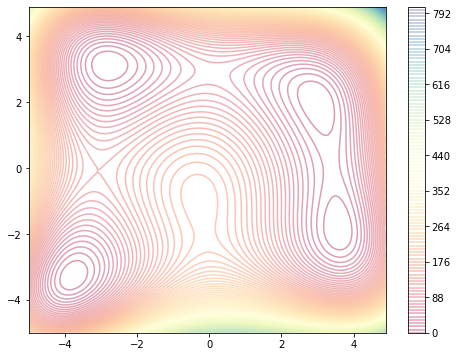

In [4]:
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
fig.colorbar(cs)
plt.show()

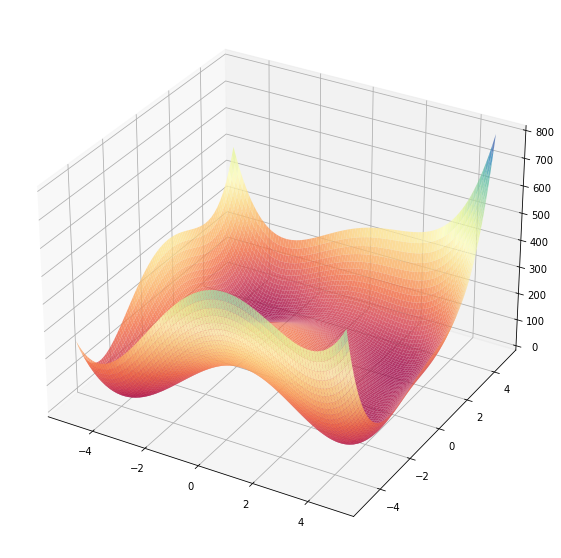

In [5]:
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection='3d')    
ax.plot_surface(X, Y, Z, cmap='Spectral', rcount=100,
                ccount=100, norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()),
                shade=False, antialiased=True, alpha=0.8)
plt.show()

We'll start with a random point $x$ as we've done before. We'll then use a Normal distribution to draw points around $x$, this time generating 20 points around $x$ instead of 1.

In [6]:
x = np.random.rand(2) * 4 - 2
x

array([ 1.19826632, -1.7318823 ])

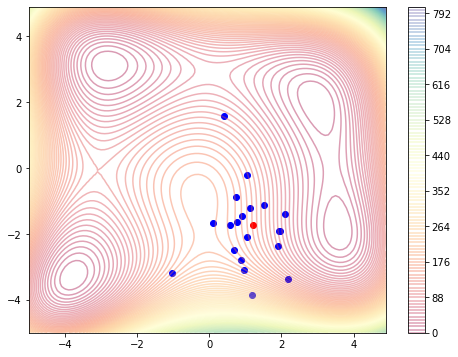

In [7]:
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(20)])
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
plt.scatter(x_t[:, 0], x_t[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs)
plt.show()

Having this population of points will enable us to explore the space around $x$ before moving on to the next step, which can better inform movement in the search space. However, these points might overlap or cover spaces that have already been explored. Generating too many points could slow down search, requiring more evaluations of the objective function. In many applications, that is costly.

Performing random optimization but sampling more than 1 point leads to the $(1+\lambda)$ Evolutionary Strategy. 

    Initialize x randomly in ℝ
    while not terminate
        x_p = x
        for i in [1,λ]
            x_i = x_p + 𝑁(0, 1)
            if f(x_i) < f(x)
                x = x_i
        x_p = x
    return x_p

In the scope of evolutionary algorithms, we'll refer to $x$ as a parent and all $x'$ points as offspring. Each point can also be referred to as an individual in a population, and $f(x)$ is called the fitness of the individual. Each iteration of the algorithm is called a generation.

The $(\mu/\rho,\lambda)$ or $(\mu/\rho+\lambda)$ notation signifies the configuration of parents and offspring. In this notation, $\mu$ is the number of parents, $\rho$ is the number of parents involved in creating the offspring, and $\lambda$ is the number of offspring. $(\mu/\rho+\lambda)$ means the parents can be included in the next population, whereas $(\mu/\rho,\lambda)$ means the parents are not included. $(1+\lambda)$ therefore means that 1 parent is involved in creating a population of $\lambda$ offspring and can be included in the next generation (ie, if $f(x) < f(x') \forall x'$, $x$ does not change).

In the next section, we'll see CMA-ES, a $(\mu/\mu_I,\lambda)$ algorithm where a transformation of $\mu$, $\mu_I$, will inform the next population but it will not be included in the next population.

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    Implement the $(1+\lambda)$ evolutionary strategy and test it on the Himmelblau function. Study the impact of the $\lambda$ parameter by modifying it and re-running the optimization. What is the best $\lambda$ value for this problem?
</div>

In [ ]:
# %load solutions/4_1plusES.py

## Approximating the gradient

In the $(1+\lambda)$ ES, we move from the best point in a population to the best point in the next randomly sampled population. However, with the population information, we can do better than that; we can move in the direction of the gradient approximated by the fitness values of the population. This can also better use the full population information, combining all fitness information instead of selecting the best fitness value.

In [ ]:
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(10)])
fits = himmelblau(x_t[:, 0], x_t[:, 1])

fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

First we normalize all fitness values by the average $\mu(f(x))$ and standard deviation $\sigma(f(x))$ of the population. This is to make the movement based on the relative fitness in the population as opposed to the absolute fitness in the search space.

$A = \frac{f(x) - \mu(f(x))}{\sigma(f(x))}$

We'll then define a vector at each point, $x_i - x$. Note that since $x_i = x + N(0, 1)$, we could store just this original random sampled point from $N(0, 1)$ as our vector.

$N_i = x_i - x$

We multiply $A$ by all individual vectors which scales the vector magnitude by the relative fitness. Finally, we sum all vectors and divide by $\lambda$ to get the weighted average.

$\frac{1}{\lambda}\sum_i A_i N_i$

This is equivalent to the dot product and is used as our gradient approximation. Since we're minimizing, we'll use the negative value to do gradient descent.

$\nabla f \approx -\frac{A \cdot N}{\lambda}$

In [ ]:
A = (fits - np.mean(fits)) / np.std(fits)
N = x_t - x
G = -np.dot(A, N) / 10

In [ ]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1])
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

We have our approximate gradient direction, but how far should we move in it? We'll define a learning rate variable $\alpha$ as the fixed magnitude of movement for now, so our update of $x$ is then

$x = x - \alpha\frac{A \cdot N}{\lambda}$

Let's put this all together as an Evolutionary Strategy

    Initialize x randomly in ℝ
    x_best = x
    while not terminate
        for i in [1,λ]
            N_i = 𝑁(0, 1)
            F_i = f(x + N_i)
            if F_i < f(x_best)
                x_best = x + N_i
        A = (F−𝜇(F))/𝜎(F)
        x = x - 𝛼(A⋅N)/𝜆
    return x_best

<div class="alert alert-info">
    <h3>Discussion</h3>
    
What is this Evolutionary Strategy in $(+,)$ notation? Is it a $(1+\lambda)$ ES? Why or why not? Discuss in your group.
</div>

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    
Implement this evolutionary strategy and test it on the Himmelblau function. Study the impact of the $\alpha$ parameter by modifying it and re-running the optimization. How does this ES compare to the $(1+\lambda)$ ES?
</div>

In [ ]:
# %load solutions/5__es.py